In [162]:
from functools import partial
from numbers import Complex
from typing import Callable
from math import pi, e

import PIL
import glob
import imageio
import matplotlib.pyplot as plt 
import numpy as np


In [163]:
def douady_hubbard_polynomial(z: Complex,
                              c: Complex) -> Complex:
    """
    Monic and centered quadratic complex polynomial
    https://en.wikipedia.org/wiki/Complex_quadratic_polynomial#Map
    """
    return z ** 2 + c

In [164]:
def Circle_Path(radius, iterations):
    r = radius
    c_n = []
    circle = 2*pi
    for t in range(iterations):
        c = r*e**(t * circle/iterations * 1j)
        c_n.append(c)
    return c_n

In [165]:
def julia_set(mapping: Callable[[Complex], Complex], 
            *, 
            min_coordinate: Complex, 
            max_coordinate: Complex, 
            width: int, 
            height: int, 
            iterations_count: int = 256, 
            threshold: float = 2.) -> np.ndarray:
    im, re = np.ogrid[min_coordinate.imag: max_coordinate.imag: height * 1j, min_coordinate.real: max_coordinate.real: width * 1j]

    z = (re + 1j * im).flatten()

    live, = np.indices(z.shape)
    iterations = np.empty_like(z, dtype=int)

    for i in range(iterations_count):
        z_live = z[live] = mapping(z[live])
        escaped = abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
        if live.size == 0:
            break
    else: 
        iterations[live] = iterations_count

    return iterations.reshape((height, width))


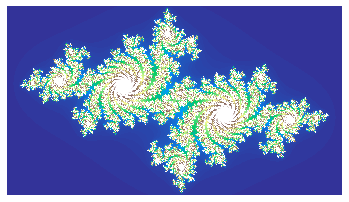

In [166]:
if __name__ == '__main__':
    mapping = partial(douady_hubbard_polynomial, c=-0.7 + 0.27015j)

    image = julia_set(mapping, min_coordinate=-1.6-0.9j, max_coordinate=1.6+0.9j,width=1920, height=1080)

    plt.axis('off')
    plt.imshow(image, cmap='terrain', origin='lower')
    plt.show()

In [167]:
def animator(Gif_out):
    with imageio.get_writer(Gif_out, mode='I') as writer:
        filenames = glob.glob('plot*.png')
        filenames = sorted(filenames)
        print(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else: 
                continue
            image = imageio.imread(filename)
            writer.append_data(image)

In [168]:
def generate_images(func, radius:int , iters: int, width, height, min_coord: Complex, max_coord: Complex):
    
    c_n = Circle_Path(radius, iters)

    for i in range(iters):
        mapping = partial(func, c = c_n[i])

        image = julia_set(mapping, 
                min_coordinate= min_coord, 
                max_coordinate= max_coord, 
                width=width, 
                height=height)
        plt.axis('off')
        plt.imshow(image, cmap='terrain')
        plt.savefig('plot_{:04d}.png'.format(i), dpi=400)

In [173]:
def sample_plot(func, width, height, min_coord, max_coord):
    
    c_n = Circle_Path(1, 16)
    examples = []
    for i in range(16): 
        mapping = partial(func, c = c_n[i])
        example = julia_set(mapping, 
        min_coordinate=min_coord, 
        max_coordinate=max_coord,
        width=width,
        height=height)
        examples.append(example)
        
    
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.axis('off')
        plt.subplot(4,4, i+1)
        plt.imshow(examples[i], cmap='terrain')
    plt.show()

In [174]:
def tan_func(z: Complex, c: Complex) -> Complex:
    return np.tan(z) ** 3 + c

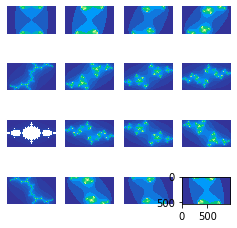

In [175]:
sample_plot(douady_hubbard_polynomial,960,540,-1.5-1j,1.5+1j)

['plot_0000.png', 'plot_0001.png', 'plot_0002.png', 'plot_0003.png', 'plot_0004.png', 'plot_0005.png', 'plot_0006.png', 'plot_0007.png', 'plot_0008.png', 'plot_0009.png', 'plot_0010.png', 'plot_0011.png', 'plot_0012.png', 'plot_0013.png', 'plot_0014.png', 'plot_0015.png', 'plot_0016.png', 'plot_0017.png', 'plot_0018.png', 'plot_0019.png', 'plot_0020.png', 'plot_0021.png', 'plot_0022.png', 'plot_0023.png', 'plot_0024.png', 'plot_0025.png', 'plot_0026.png', 'plot_0027.png', 'plot_0028.png', 'plot_0029.png', 'plot_0030.png', 'plot_0031.png', 'plot_0032.png', 'plot_0033.png', 'plot_0034.png', 'plot_0035.png', 'plot_0036.png', 'plot_0037.png', 'plot_0038.png', 'plot_0039.png', 'plot_0040.png', 'plot_0041.png', 'plot_0042.png', 'plot_0043.png', 'plot_0044.png', 'plot_0045.png', 'plot_0046.png', 'plot_0047.png', 'plot_0048.png', 'plot_0049.png', 'plot_0050.png', 'plot_0051.png', 'plot_0052.png', 'plot_0053.png', 'plot_0054.png', 'plot_0055.png', 'plot_0056.png', 'plot_0057.png', 'plot_0058.pn

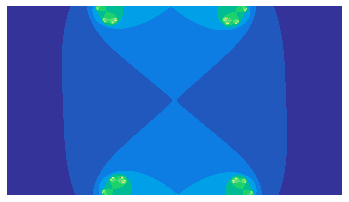

In [177]:
func = lambda z, c : np.tan(z) ** 3 + c
generate_images(douady_hubbard_polynomial,1,100,3840,2160,-1.5-1j,1.5+1j)
Gif_out = 'douady.gif'
animator(Gif_out)

In [171]:
def generate_mandelbrot(func, width, height, min_coord, max_coord):
    
    mapping = partial(func, z = 1 + 0j)
    example = julia_set(mapping, 
        min_coordinate=min_coord, 
        max_coordinate=max_coord,
        width=width,
        height=height)

    plt.axis('off')
    plt.imshow(example, cmap='terrain')
    plt.show()